In [94]:
import pandas as pd

files_dir = f"/home/rudi/Projects/profile-based-anomaly-detection/data/dotlist_induced6"

annotations_path = f"{files_dir}/annotations.csv"
annotations = pd.read_csv(annotations_path)
anomalies = pd.read_csv("/home/rudi/Projects/profile-based-anomaly-detection/data/dotlist_induced6/anomalies.csv")

In [95]:
from src.datamodules.components.sequence_dataset import SequenceDataset

sequences = SequenceDataset(
    annotations=annotations_path,
    events="/home/rudi/Projects/profile-based-anomaly-detection/data/dotlist_induced6/events.json"
)

In [96]:
cases = {}
for i, sequence in enumerate(sequences):
    flattened = sequence.squeeze().tolist()
    case = list(map(lambda x: sequences.types[x], flattened))
    cases[i] = case

In [98]:
requests = {}
for i, row in annotations.iterrows():
    file_name = row['MESSAGE']
    content = open(f"{files_dir}/documents/{file_name}", "r").read().split(" ")
    requests[file_name] = content

In [99]:
import tqdm

grams = {}
for file_name, tokens in tqdm.tqdm(cases.items()):
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            other_tokens = tokens.copy()
            other_tokens.pop(j)
            k = tuple(other_tokens)
            if k not in grams:
                grams[k] = []
            grams[k].append(tokens[j])

100%|██████████| 1000/1000 [00:00<00:00, 71109.18it/s]


In [100]:
# turn each array of middle-words into a probability vector
gram_probabilities = {}
for k, words in tqdm.tqdm(grams.items()):
    # create a dictionary of word -> count
    if len(set(words)): # only do this when there are different possibilities for a middle word
        d = {} ; n = 0
        for w in words:
            if w not in d:
                d[w] = 0    # set count to 0 for each new word
            d[w] += 1       # increment count for each existing word
            n += 1          # increment total number of examined words
        for w, c in d.items():
            d[w] = float(format(float(c) / n, '.4f'))  # compute probabilities with 4 decimal digits
        gram_probabilities[k] = d

100%|██████████| 127/127 [00:00<00:00, 23176.98it/s]


In [101]:
len(gram_probabilities)

127

In [102]:
def compute_complete_prob(req, gram_probabilities):
    acc_prob = 1
    for i, t in enumerate(req):
        others = req.copy()
        others.pop(i)
        probabilities: dict = gram_probabilities.get(tuple(others))
        if probabilities is None:
            return 0
        acc_prob *= probabilities.get(t, 0)
    return acc_prob

In [103]:
req = cases[list(cases.keys())[0]]

In [104]:
compute_complete_prob(req, gram_probabilities)

1.0

In [105]:
probs = {}
for file_name, content in cases.items():
    probs[file_name] = compute_complete_prob(content, gram_probabilities)

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'k',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'k',
 'xtick.bottom': False,
 'xtick.color': 'k',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'k',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":10,
                                "axes.titlesize":14,
                                "axes.labelsize":10,
                                "xtick.labelsize": 9,
                                "ytick.labelsize": 9})

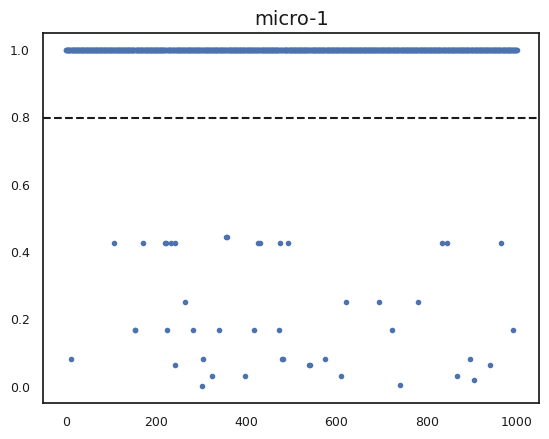

In [107]:
from matplotlib import pyplot as plt 

data = list(probs.values())
import numpy

probs_array = numpy.array(data)
mean = probs_array.mean()
std = probs_array.std()

th = mean - 1 * std

plt.scatter(x=range(len(data)), y=data, marker='.')
plt.axhline(y=th, color='k', linestyle='--')
plt.title('micro-1')
plt.show()

In [108]:
y_true = []
y_pred = []
# for i, row in annotations.iterrows():
#     file_name = row['MESSAGE']
#     anomaly = row['CODE'] > 0
#     y_true.append(anomaly)
#     anomaly_prediction = compute_complete_prob(requests[file_name], gram_probabilities) < th
#     y_pred.append(anomaly_prediction)

for i in range(len(sequences)):
    is_anomaly = (anomalies['CORRELATION_ID'] == i).any()
    predicted_anomaly = compute_complete_prob(cases[i], gram_probabilities) < th
    y_true.append(is_anomaly)
    y_pred.append(predicted_anomaly)

In [109]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print(fbeta_score(y_true, y_pred, beta=2))
print(fbeta_score(y_true, y_pred, beta=3))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       946
        True       0.87      0.72      0.79        54

    accuracy                           0.98      1000
   macro avg       0.93      0.86      0.89      1000
weighted avg       0.98      0.98      0.98      1000

[[940   6]
 [ 15  39]]
0.7471264367816093
0.7344632768361583
